# Backtest Strategy

{"LP_positions":[{"burn":{"X_collect":39202067,"X_fee":26276,"X_reserve":39175791,"Y_collect":2957290046950974752,"Y_fee":6986750038945891,"Y_reserve":2950303296912028861,"burn_price":187346581792.3359,"sqrtPriceX96":34292762409689812156959914401915150},"info":{"APR":49.86942210869397,"Impermanent_loss":-0.8396869665135571,"PnL":0.9563998760571447,"X_start":0.2777777777777778,"X_start_wei":27777777,"Y_start":5.0,"Y_start_wei":5000000000000000000,"Yield":0.11671290954359609,"duration":604800.0,"end":"2024-03-18 00:00:00","lower_price":15.209176052737439,"start":"2024-03-11 00:00:00","upper_price":33.36133458736338},"mint":{"X_left":161599,"X_mint":43169395,"Y_left":37517937,"Y_mint":2220684294982147017,"liquidity":67920117032930,"lower_nearest_tick":257460,"pool_price":178162671869.72742,"pool_tick":259575,"upper_nearest_tick":265320},"swap":{"X_after_swap":43330994,"X_swap":-15553217,"Y_after_swap":2220684295019664954,"Y_swap":2771002696889666048,"fee_paid":8313008090668998,"sqrtPriceX

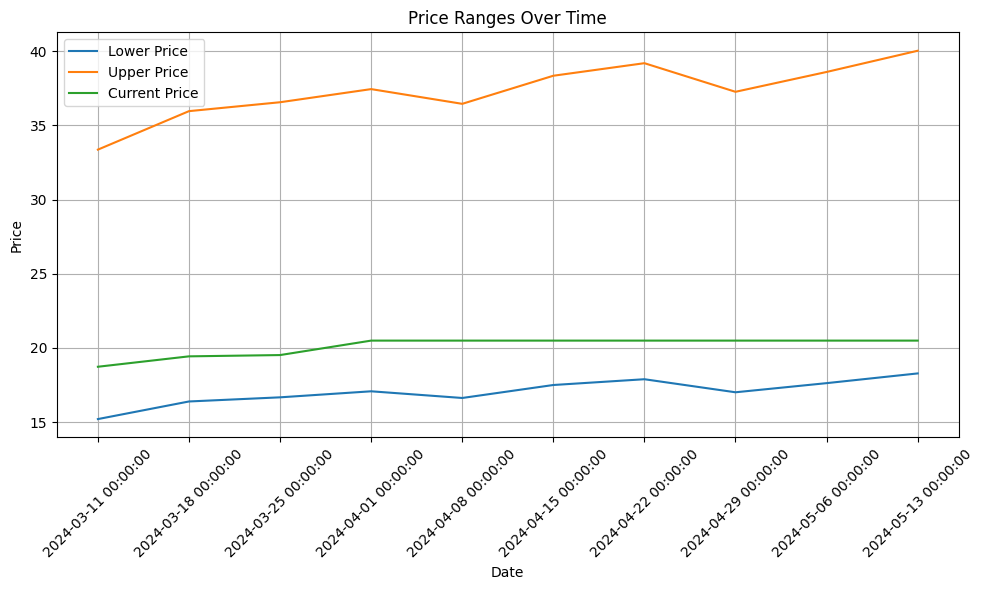

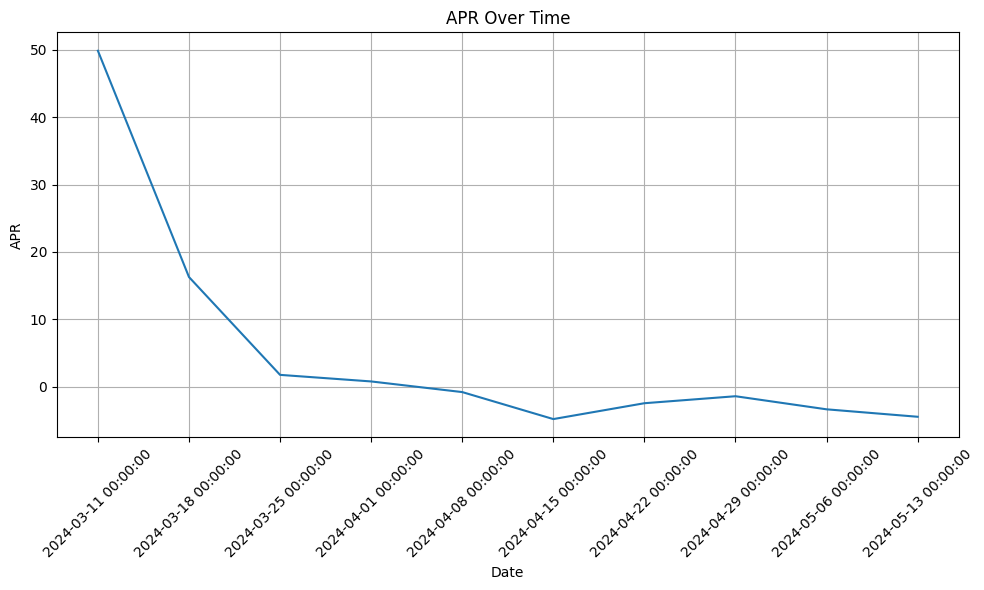

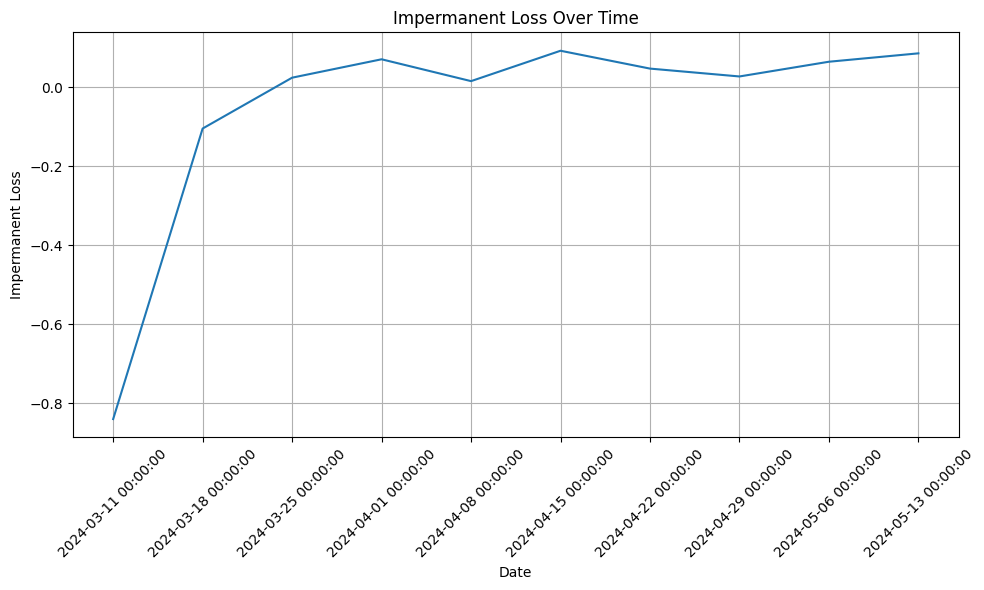

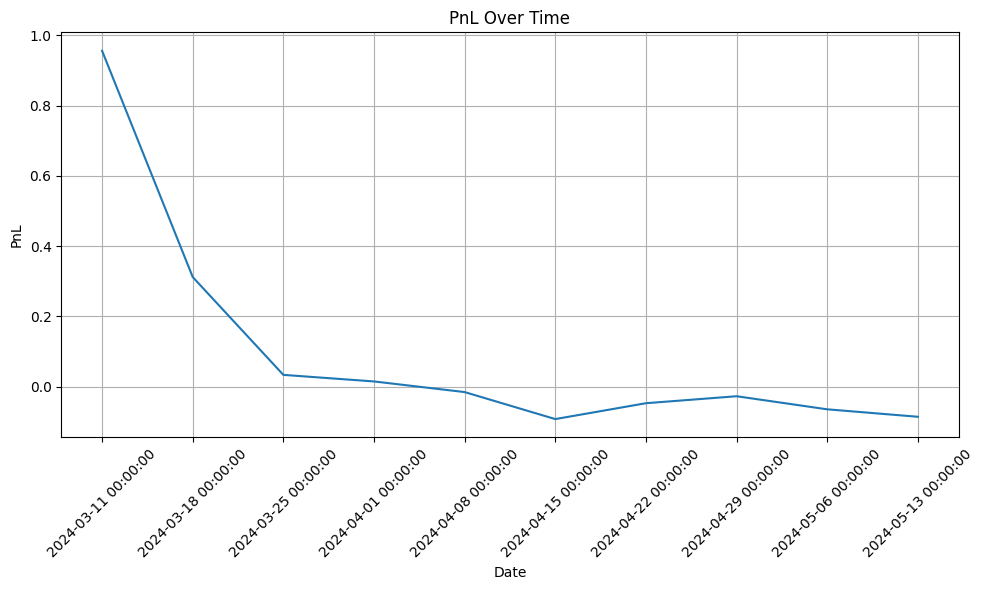

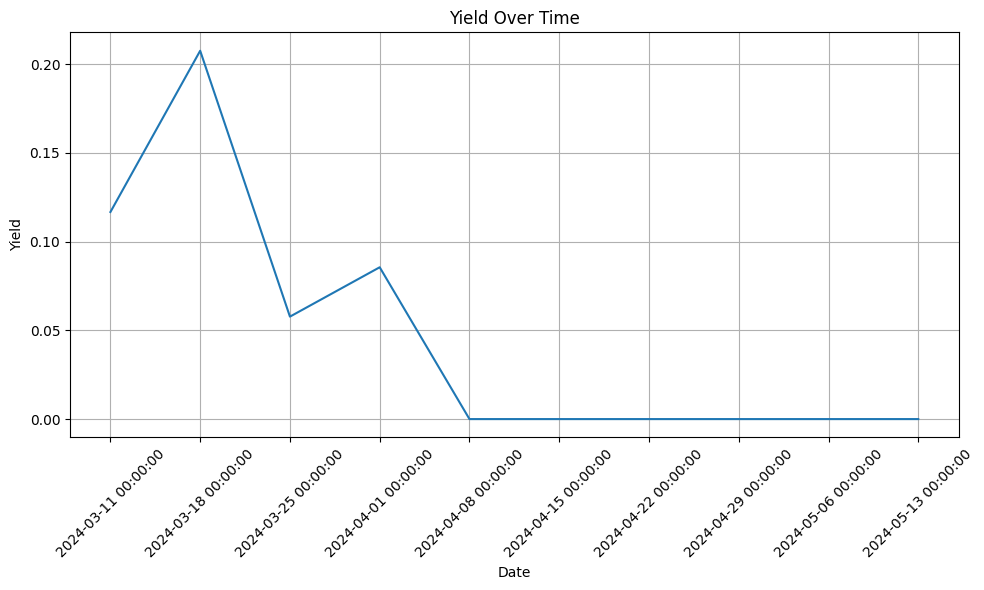

In [28]:
from datetime import datetime, timedelta
import requests
import pandas as pd
import matplotlib.pyplot as plt

def backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent):
    current_date = datetime.strptime(start_date, '%d-%m-%y')
    end_date = datetime.strptime(end_date, '%d-%m-%y')

    all_positions = []

    while current_date <= end_date:
        curr_date_str = current_date.strftime('%Y-%m-%d')
        # Step 3: Predict new positions
        ddpg_action, ppo_action = get_inference(ddpg_agent_path, ppo_agent_path, pool_id, curr_date_str)
        
        # Step 4: Rebalance portfolio
        start_interval = current_date
        end_interval = current_date + timedelta(days=rebalancing_frequency)
        start_date_str = start_interval.strftime('%Y-%m-%d %H:%M:%S')
        end_date_str = end_interval.strftime('%Y-%m-%d %H:%M:%S')

        if agent == "ddpg":
            price_lower = ddpg_action['price_lower']
            price_upper = ddpg_action['price_upper']
        else:
            price_lower = ppo_action['price_lower']
            price_upper = ppo_action['price_upper']

        # Collect all positions in a list
        all_positions.append({
            "start": start_date_str,
            "end": end_date_str,
            "lower_price": price_lower,
            "upper_price": price_upper,
        })

        # Move to the next rebalancing date
        current_date += timedelta(days=rebalancing_frequency)

    # Step 5: Send all positions to the simulator API in a single request
    response = simulate_position(X_reserve, Y_reserve, all_positions)
    response_json = response.json()

    if 'LP_positions' not in response_json:
        print(f"Error: 'LP_positions' not found in response or response is None: {response_json}")
        return pd.DataFrame(), pd.DataFrame()

    # Process the response to save data to a DataFrame
    data_df, results_df = save_data_to_df(response_json)

    return data_df, results_df

def get_inference(ddpg_agent_path='model_storage/ddpg/ddpg_1', ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm', pool_id="0xcbcdf9626bc03e24f779434178a73a0b4bad62ed", date_str='2024-05-05'):
    url = "http://127.0.0.1:8000/predict_action/"
    data = {
        "pool_id": pool_id,
        "ddpg_agent_path": ddpg_agent_path,
        "ppo_agent_path": ppo_agent_path,
        "date_str": date_str
    }
    response = requests.post(url, json=data)
    response_json = response.json()
    ddpg_action = response_json['ddpg_action']
    ppo_action = response_json['ppo_action']
    
    return ddpg_action, ppo_action

def simulate_position(X_reserve, Y_reserve, positions):
    vector = {
        "X": X_reserve,
        "Y": Y_reserve,
        "positions": positions
    }
    url = "http://localhost:5050/MVP"
    response = requests.post(url, json=vector)
    print(response.text)

    return response

def save_data_to_df(response_json):
    data = []
    for position in response_json.get('LP_positions', []):
        burn_data = position.get('burn', {})
        info_data = position.get('info', {})
        mint_data = position.get('mint', {})
        swap_data = position.get('swap', {})

        data.append({
            'start': info_data.get('start'),
            'end': info_data.get('end'),
            'curr_price': burn_data.get('burn_price') / 1e10,
            'lower_price': info_data.get('lower_price'),
            'upper_price': info_data.get('upper_price'),
            'X_start': info_data.get('X_start'),
            'Y_start': info_data.get('Y_start'),
            'liquidity': mint_data.get('liquidity'),
            'X_left': mint_data.get('X_left')/1e8,
            'X_mint': mint_data.get('X_mint')/1e8,
            'Y_left': mint_data.get('Y_left')/1e18,
            'Y_mint': mint_data.get('Y_mint')/1e18,
            'X_fee': burn_data.get('X_fee')/1e8,
            'X_reserve': burn_data.get('X_reserve')/1e8,
            'Y_fee': burn_data.get('Y_fee')/1e18,
            'Y_reserve': burn_data.get('Y_reserve')/1e18,
            'APR': info_data.get('APR'),
            'Impermanent_loss': info_data.get('Impermanent_loss'),
            'PnL': info_data.get('PnL'),
            'Yield': info_data.get('Yield')
        })

    final_result = response_json.get('final_result', {})
    final_result_data = {
        'final_PnL': final_result.get('PnL'),
        'final_fee_value': final_result.get('fee_value')/1e18,
        'final_fee_yield': final_result.get('fee_yield'),
        'final_impermanent_loss': final_result.get('impermanent_loss'),
        'final_portfolio_value_end': final_result.get('portfolio_value_end')/1e18,
        'final_portfolio_value_start': final_result.get('portfolio_value_start')/1e18
    }

    data_df = pd.DataFrame(data)
    final_result_df = pd.DataFrame([final_result_data])

    return data_df, final_result_df

def plot_prices_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['lower_price'], label='Lower Price')
    plt.plot(data_df['start'], data_df['upper_price'], label='Upper Price')
    plt.plot(data_df['start'], data_df['curr_price'], label='Current Price')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Ranges Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_apr_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['APR'])
    plt.xlabel('Date')
    plt.ylabel('APR')
    plt.title('APR Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_il_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Impermanent_loss'])
    plt.xlabel('Date')
    plt.ylabel('Impermanent Loss')
    plt.title('Impermanent Loss Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_pnl_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['PnL'])
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('PnL Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_yield_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Yield'])
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.title('Yield Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
start_date = '11-03-24'
end_date = '15-05-24'
ddpg_agent_path = 'model_storage/ddpg/ddpg_1'
ppo_agent_path = 'model_storage/ppo/lstm_actor_critic_batch_norm'
pool_id = "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed"
agent = "ddpg"

budget_eth=10 # Initail total ETH reserves for liquidity position
btc_eth_price=18 #btc/ETH price
X_reserve = (budget_eth/2)/btc_eth_price
Y_reserve = budget_eth/2
rebalancing_frequency = 7

data_df, results_df = backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent)

# Plotting the results
plot_prices_over_time(data_df)
plot_apr_over_time(data_df)
plot_il_over_time(data_df)
plot_pnl_over_time(data_df)
plot_yield_over_time(data_df)

In [32]:
results_df

,final_PnL,final_fee_value,final_fee_yield,final_impermanent_loss,final_portfolio_value_end,final_portfolio_value_start
0,3.140934,0.050648,0.47364,-2.667294,10.978494,10.693273


In [33]:
data_df

,start,end,curr_price,lower_price,upper_price,X_start,Y_start,liquidity,X_left,X_mint,Y_left,Y_mint,X_fee,X_reserve,Y_fee,Y_reserve,APR,Impermanent_loss,PnL,Yield
0,2024-03-11 00:00:00,2024-03-18 00:00:00,18.734658,15.209176,33.361335,0.277778,5.000000,67920117032930,1.615990e-03,0.431694,3.751794e-11,2.220684,0.000263,0.391758,0.006987,2.950303,49.869422,-0.839687,0.956400,0.116713
1,2024-03-18 00:00:00,2024-03-25 00:00:00,19.435193,16.395325,35.954317,0.392021,2.957290,69293151237027,7.021400e-04,0.445622,3.991209e-11,1.936889,0.000524,0.416505,0.011767,2.492490,16.273228,-0.104483,0.312089,0.207606
2,2024-03-25 00:00:00,2024-04-01 00:00:00,19.521693,16.674392,36.554062,0.417029,2.504258,69759489071818,1.427300e-04,0.429728,4.056963e-11,2.253930,0.000151,0.426218,0.003191,2.322292,1.749001,0.024202,0.033542,0.057745
3,2024-04-01 00:00:00,2024-04-08 00:00:00,20.495785,17.080776,37.438531,0.426370,2.325482,70264356864818,2.214200e-04,0.443151,4.138319e-11,1.992568,0.000177,0.404900,0.005845,2.757684,0.772481,0.070754,0.014815,0.085569
4,2024-04-08 00:00:00,2024-04-15 00:00:00,20.495785,16.630599,36.446645,0.405077,2.763529,69826078681180,-1.000000e-08,0.385147,4.905285e-04,3.170300,0.000000,0.385147,0.000000,3.170300,-0.806833,0.015474,-0.015474,0.000000
5,2024-04-15 00:00:00,2024-04-22 00:00:00,20.495785,17.504700,38.339204,0.385147,3.170300,70698071825204,3.892700e-04,0.421167,4.219068e-11,2.421828,0.000000,0.421167,0.000000,2.421828,-4.815168,0.092346,-0.092346,0.000000
6,2024-04-22 00:00:00,2024-04-29 00:00:00,20.495785,17.893627,39.185029,0.421167,2.421828,71621844482119,2.063100e-04,0.437021,4.330306e-11,2.091668,0.000000,0.437021,0.000000,2.091668,-2.460545,0.047189,-0.047189,0.000000
7,2024-04-29 00:00:00,2024-05-06 00:00:00,20.495785,17.014655,37.257140,0.437021,2.091668,70092522689348,-1.000000e-08,0.400472,7.744639e-04,2.837750,0.000000,0.400472,0.000000,2.837750,-1.422815,0.027287,-0.027287,0.000000
8,2024-05-06 00:00:00,2024-05-13 00:00:00,20.495785,17.630131,38.593950,0.400472,2.837750,70720537030800,2.743400e-04,0.424718,4.234241e-11,2.333686,0.000000,0.424718,0.000000,2.333686,-3.366134,0.064556,-0.064556,0.000000
9,2024-05-13 00:00:00,2024-05-20 00:00:00,20.495785,18.285033,40.022832,0.424718,2.333686,71457847209409,3.859700e-04,0.449646,4.362370e-11,1.813289,0.000000,0.449646,0.000000,1.813289,-4.472136,0.085767,-0.085767,0.000000


# Discrete Positions

In [ ]:
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import matplotlib.pyplot as plt

def backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent):
    current_date = datetime.strptime(start_date, '%d-%m-%y')
    end_date = datetime.strptime(end_date, '%d-%m-%y')

    all_data = []
    final_results = None

    while current_date <= end_date:
        curr_date_str = current_date.strftime('%Y-%m-%d')
        # Step 3: Predict new positions
        ddpg_action, ppo_action = get_inference(ddpg_agent_path, ppo_agent_path, pool_id, curr_date_str)
        
        # Step 4: Rebalance portfolio
        start_interval = current_date
        end_interval = current_date + timedelta(days=rebalancing_frequency)
        start_date_str = start_interval.strftime('%Y-%m-%d %H:%M:%S')
        end_date_str = end_interval.strftime('%Y-%m-%d %H:%M:%S')

        if agent == "ddpg":
            price_lower = ddpg_action['price_lower']
            price_upper = ddpg_action['price_upper']
        else:
            price_lower = ppo_action['price_lower']
            price_upper = ppo_action['price_upper']

        response = simulate_position(X_reserve, Y_reserve, start_date_str, end_date_str, price_lower, price_upper)
        response_json = response.json()
        data_df, results_df = save_data_to_df(response_json)

        if 'LP_positions' not in response_json:
            print(f"Error: 'LP_positions' not found in response or response is None: {response_json}")
            break

        # Append the data to the all_data list
        all_data.extend(data_df.to_dict('records'))
        final_results = results_df.to_dict('records')[0]

        # Move to the next rebalancing date
        current_date += timedelta(days=rebalancing_frequency)
        first_position = response_json['LP_positions'][0]
        X_reserve = first_position['burn']['X_reserve']/1e8
        Y_reserve = first_position['burn']['Y_reserve']/1e18

    # Create DataFrame from all_data
    final_data_df = pd.DataFrame(all_data)
    final_results_df = pd.DataFrame([final_results])

    return final_data_df, final_results_df

def get_inference(ddpg_agent_path='model_storage/ddpg/ddpg_1', ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm', pool_id="0xcbcdf9626bc03e24f779434178a73a0b4bad62ed", date_str='2024-05-05'):
    url = "http://127.0.0.1:8000/predict_action/"
    data = {
        "pool_id": pool_id,
        "ddpg_agent_path": ddpg_agent_path,
        "ppo_agent_path": ppo_agent_path,
        "date_str": date_str
    }
    response = requests.post(url, json=data)
    response_json = response.json()
    ddpg_action = response_json['ddpg_action']
    ppo_action = response_json['ppo_action']
    
    return ddpg_action, ppo_action

def simulate_position(X_reserve=0.01, Y_reserve=0.18, start_date="2024-03-01 00:00:00", end_date="2024-03-29 00:00:00", lower_price=16.0, upper_price=20.0):
    vector = {
        "X": X_reserve,
        "Y": Y_reserve,
        "positions": [
            {
                "start": start_date,
                "end": end_date,
                "lower_price": lower_price,
                "upper_price": upper_price,
            },
        ]
    }
    url = "http://localhost:5050/MVP"
    response = requests.post(url, json=vector)
    print(response.text)

    return response

def save_data_to_df(response_json):
    data = []
    for position in response_json.get('LP_positions', []):
        burn_data = position.get('burn', {})
        info_data = position.get('info', {})
        mint_data = position.get('mint', {})
        swap_data = position.get('swap', {})

        data.append({
            'start': info_data.get('start'),
            'end': info_data.get('end'),
            'curr_price':burn_data.get('burn_price')/1e10,
            'lower_price': info_data.get('lower_price'),
            'upper_price': info_data.get('upper_price'),
            'X_start': info_data.get('X_start'),
            'Y_start': info_data.get('Y_start'),
            'liquidity': mint_data.get('liquidity'),
            'X_left': mint_data.get('X_left'),
            'X_mint': mint_data.get('X_mint'),
            'Y_left': mint_data.get('Y_left'),
            'Y_mint': mint_data.get('Y_mint'),
            'X_fee': burn_data.get('X_fee'),
            'X_reserve': burn_data.get('X_reserve'),
            'Y_fee': burn_data.get('Y_fee'),
            'Y_reserve': burn_data.get('Y_reserve'),
            'APR': info_data.get('APR'),
            'Impermanent_loss': info_data.get('Impermanent_loss'),
            'PnL': info_data.get('PnL'),
            'Yield': info_data.get('Yield')
        })

    final_result = response_json.get('final_result', {})
    final_result_data = {
        'final_PnL': final_result.get('PnL'),
        'final_fee_value': final_result.get('fee_value'),
        'final_fee_yield': final_result.get('fee_yield'),
        'final_impermanent_loss': final_result.get('impermanent_loss'),
        'final_portfolio_value_end': final_result.get('portfolio_value_end'),
        'final_portfolio_value_start': final_result.get('portfolio_value_start')
    }

    data_df = pd.DataFrame(data)
    final_result_df = pd.DataFrame([final_result_data])

    return data_df, final_result_df

def plot_prices_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['lower_price'], label='Lower Price')
    plt.plot(data_df['start'], data_df['upper_price'], label='Upper Price')
    plt.plot(data_df['start'], data_df['curr_price'], label='Current Price')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Ranges Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_apr_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['APR'])
    plt.xlabel('Date')
    plt.ylabel('APR')
    plt.title('APR Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_il_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Impermanent_loss'])
    plt.xlabel('Date')
    plt.ylabel('Impermanent Loss')
    plt.title('Impermanent Loss Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_pnl_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['PnL'])
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('PnL Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_yield_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Yield'])
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.title('Yield Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



#Usage
start_date = '01-01-23'
end_date = '29-05-24'
ddpg_agent_path = 'model_storage/ddpg/ddpg_1'
ppo_agent_path = 'model_storage/ppo/lstm_actor_critic_batch_norm'
pool_id = "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed"
agent = "ddpg"
X_reserve = 0.01
Y_reserve = 2
rebalancing_frequency = 7

data_df, results_df = backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent)
# Plotting the results